# CN calculation for wet and dry conditions using "Events Table Stratified" 


__Modification of Script__:

1. The rainfall is developed using Hydrology 2. And the hyetographs are developed using the NOAA Atlas 14 temporal distributions (four different quartiles).


2. To account for the spatial variability of the CNs within the basin, we calculate the CNs for wet and dry condition for each unique CN values within the basin.

    In Hydrology 3, for each return period, the original "Events Table Stratified" script calculates the average max potential retention value for upper 50% and lower      50%. These avg. S values are then converted to CN values for wet and dry conditions.  
    The conversion is done using the formula: S = 1000/CN - 10
    
    These CN values for wet and dry conditions are then provided as an input to the HEC-RAS model. This way the RAS model acccounts for the spatial variability of the      losses associated with different land use conditions throughout the basin.
    
    All the other calculation steps are same as described in the original "Events Stratified Table" script.




##

__Description__: 

A stratified sampling of runoff events is performed on a runoff distribution derived from 
- Rainfall distribution based on the NOAA Atlas 14 (or mean precipitation curve) data (area averaged) and
- Max. potential retention distribution based on a beta distribution.

The rainfall distribution is assumed to be represented by a generalized extreme value distribution (GEV). This GEV distribution is fitted to the data (NOAA Atlas 14 data or corresponding values for the mean precipitation curve). The maximum potential distribution variabilitity corresponds to the curve number (CN) dispersion documented by the NRCS. For the rainfall distribution and runoff distribution, this notebook sequentially calculates 
- GEV distribution parameters for the NOAA or mean precipitation curve data
- Rainfall values and probability weights for different return period events
- Max potential retention variability and distribution parameters
- Partition for the max potential distribution for calculating the runoff distribution
- Runoff as a function of the return interval (i.e., return period)
- Runoff event probability weights
- A stratified sampling of runoff, where for each return interval the sampling includes
    - Event weight
    - Runoff value
    - Max. potential retention value
    - Rainfall value




__Input__: 
- Parameters: curve number and initial abstraction ratio; the probable maximum precipitation; return intervals for stratified sampling; maximum return interval limit for the stratified sampling bins;  the volume, region, and duration ([See map for volume and region](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html)).
        
- The area averaged precipitation frequency data for the specified duration.

- `DataRepository` folder which contains the following:
    - The *NEH630_Table_10_1.json* which contains information about the spread of possible values around the provided (expected) curve number. [Source](https://www.wcc.nrcs.usda.gov/ftpref/wntsc/H&H/NEHhydrology/ch10.pdf).


__Output__: This script gives the wet and dry condition CN values for each unique CN value within a basin.

---
## Load Libraries, Parameters, and Data:
### Libraries:

In [117]:
import sys
sys.path.append('../../core')
from hydromet import*
from hydromet_stratified import*
import hydromet_JSON_to_DSS
import mean_frequency_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

### Parameters: 
#### Local (site specific):

In [6]:
## Excess rainfall parameters:
#CN  = 93  # Curve number, must be an integer
# Commenting out CN because later in the code, we will loop for all the unique values of CN from a basin

mu  = 0.2  # Intial abstraction ratio parameter
PMP = 32.53  # [inches]; Probable maximum precipitation for the selected duration 
Return_Intervals = np.array([2, 5, 10, 25, 50, 100, 200, 500, 1000, 2000, 3000])  # Return intervals for calculating runoff values.
RI_upper_bound = 3700  # Upper Limit of recurrence interval evaluation, suggest not changing this value
lower_limit = 1 # Lower limit of NOAA Atlas 14 precipitation values
Aerial_Reduction = 1  # Aerial reduction factor
duration = 12  # [hours]; Event duration;  must be a duration in the input Precip_Table file
Time_Extend = 12.0 # Model run time extension beyond the hyetograph (24-hour) period.
hydrology_IDs = [1, 2, 3, 4]  # ID's of the different hydrology scenarios considered. 


## Mean curve parameters:
return_intervals_mc = np.array([1.01, 1.05, 1.11, 1.25, 20, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 1/2E-06, 1/1E-06, 1/5E-07, 1/2E-07, 1/1E-07]) # Additional return intervals for the mean curve inputs
CL = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.995, 0.999]) # Confidence limits

## Integration parameter:
n_partition = 30  # Define number of partitions of max potential retention distribution; this controls the resolution of the integration of int p(Q|S)p(S) dS

## Filenames and paths:
Project_Area = 'JoCo'          # Project area name
Pluvial_Model = 'P01'                # Pluvial model name
BCN = 'TurkeyCreek'               # Domain/boundary condition name 071200040505 Kansas 102500170609 Nevada '160600140303'

precip_table = '{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # NOAA Data
precip_mean_curve_input_table = f'Mean_Curve_Input_{Project_Area}.csv'
precip_mean_curve_table = f'MeanCurve_{Project_Area}.csv'
CN_Distribution = 'NEH630_Table_10_1.json'
nrcs_precip_table = '{0}_{1}_{2}_nrcs_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # NRCS Data
atlas14_precip_table = '{0}_{1}_{2}_atlas_temporal_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # Atlas 14 Temporal Data

root_dir = pl.Path(os.getcwd())
outputs_dir = root_dir/'Outputs'
precip_table_dir = outputs_dir/precip_table
nrcs_precip_table_dir = outputs_dir/nrcs_precip_table   
atlas14_precip_table_dir = outputs_dir/atlas14_precip_table 
precip_mean_curve_input_table_dir = outputs_dir/precip_mean_curve_input_table
precip_mean_curve_table_dir = outputs_dir/precip_mean_curve_table
datarepository_dir = root_dir.parent.parent/'DataRepository'
bin_dir = root_dir.parent.parent/'bin'

## Options:
display_print = False

## Options:
save_dss = False
remove_ind_dur = True                              # Remove individual duration files which are combined at the end of this notebook
run_dur_dic = {'12': 1, '12': 1, '12': 1, '12': 1}  # Run durations in days

##### Convert all paths to objects:

In [7]:
outputs_dir = pl.Path(outputs_dir)
precip_table_dir = pl.Path(precip_table_dir)
precip_mean_curve_input_table_dir = pl.Path(precip_mean_curve_input_table_dir)
precip_mean_curve_table_dir = pl.Path(precip_mean_curve_table_dir)
datarepository_dir = pl.Path(datarepository_dir)

### Data:
#### NOAA Atlas 14 precipitation values:

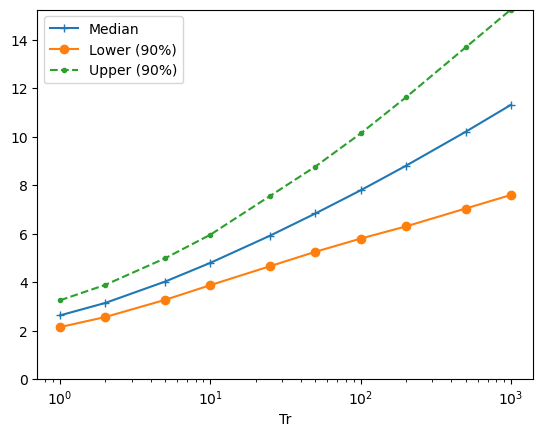

,Median,Lower (90%),Upper (90%)
Tr,,,
1,2.630202,2.146298,3.252532
2,3.142936,2.561979,3.888394


In [8]:
raw_precip = get_input_data(precip_table_dir, duration, lower_limit, display_print)
raw_precip.rename(columns = {'Expected Value': 'Median'}, inplace = True)
raw_precip.plot(style=['+-','o-','.--'], logx=True, ylim=(0, raw_precip['Upper (90%)'].max()))
plt.show()
raw_precip.head(2)

#### Fit GEV to rainfall data (find GEV parameters):

In [9]:
## Reduce precipitation by aerial reduction factor:
raw_precip_reduced = raw_precip[raw_precip.select_dtypes(include=['number']).columns]*Aerial_Reduction

## Find GEV parameter values:
df_GEV_parameters_M = GEV_parameters_Fit(raw_precip_reduced, 'Median', PMP)
df_GEV_parameters_U = GEV_parameters_Fit(raw_precip_reduced, 'Upper (90%)', PMP)
df_GEV_parameters_L = GEV_parameters_Fit(raw_precip_reduced, 'Lower (90%)', PMP)
df_GEV_parameters = pd.concat([df_GEV_parameters_M, df_GEV_parameters_L, df_GEV_parameters_U], axis=1)
df_GEV_parameters

C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey_CN\notebooks\pluvial\../../core\hydromet_stratified.py:62: RuntimeWarning:

divide by zero encountered in scalar divide



,GEV Median,GEV Lower (90%),GEV Upper (90%)
mu,2.989489,2.437020,3.691039
sigma,0.711414,0.640662,0.876187
xi,-0.147972,-0.047008,-0.180875


---
## Hydrology 2

### Mean Curve Calculation
#### Data for calculating the mean curve:

In [109]:
return_interval_Data = return_interval_data(raw_precip_reduced, return_intervals_mc, df_GEV_parameters, PMP)
return_interval_Data.head(2)

,Median,Lower (90%),Upper (90%),Log SD (Lower),Log SD (Upper),Max Log SD,mu LN
1.00,2.630202,2.146298,3.252532,0.123597,0.129102,0.129102,0.967061
1.01,2.015818,1.491622,2.520413,0.183077,0.135804,0.183077,0.701025


#### Input for calculating the mean curve:

In [110]:
mean_curve_data = mean_curve_input_table(CL, return_interval_Data, PMP, precip_mean_curve_input_table_dir)
mean_curve_data.head(2)

,0.001,0.005,0.010,0.050,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,0.950,0.990,0.995,0.999
AEP,,,,,,,,,,,,,,,,,
1.000000e-07,25.465649,26.92176,27.581355,29.193995,29.925483,30.680527,31.133505,31.460096,31.716445,31.927886,32.108068,32.265204,32.404627,32.468886,32.518014,32.524021,32.528807
2.000000e-07,24.509814,26.13090,26.870826,28.694305,29.528097,30.393050,30.914050,31.290649,31.586814,31.831469,32.040219,32.222468,32.384327,32.458976,32.516068,32.523051,32.528613


##### Calculate the mean precipitation curve:

Specified inputs_path is to a csv, loaded table.

Values increase with decreasing annual exceedance probability for all confidence limits as expected



C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey_CN\notebooks\pluvial\../../core\meanffc.py:496: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



,P_Mean_in,P_Median_in
AEP,,
0.9,2.317248,2.431417
0.5,3.213518,3.142936


C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey_CN\notebooks\pluvial\Outputs - already exists



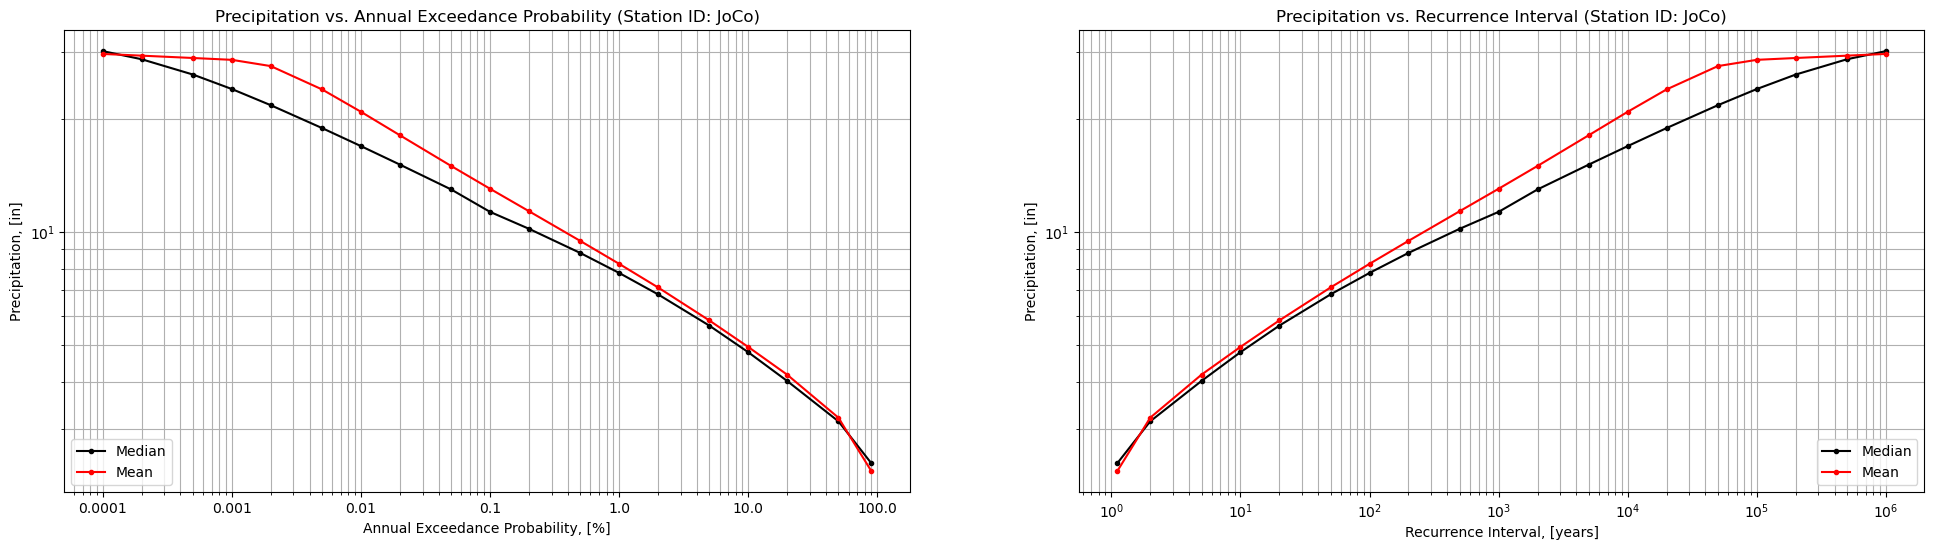

In [12]:
df = mean_frequency_curve.main(Project_Area, precip_mean_curve_input_table_dir, outputs_dir, data_type = 'P', round_decimals = 6)
plt.show()

---
### Load Mean Curve:

In [13]:
mean_curve_precip = pd.read_csv(precip_mean_curve_table_dir, index_col=0)
mean_curve_precip['Tr'] = 1.0/mean_curve_precip.index.values
mean_curve_precip.set_index('Tr', inplace = True)
mean_curve_precip.plot(style=['+-', 'o-'], logx=True, ylim=(0, PMP))
mean_curve_precip.head(2)

,P_Mean_in,P_Median_in
Tr,,
1.111111,2.317248,2.431417
2.000000,3.213518,3.142936


### Fit GEV to Mean Precipication Curve (Find GEV Parameters):

C:\Users\dneupane\AppData\Local\Temp\ipykernel_34920\980014200.py:1: FutureWarning:

The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead

C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey_CN\notebooks\pluvial\../../core\hydromet_stratified.py:62: RuntimeWarning:

divide by zero encountered in scalar divide



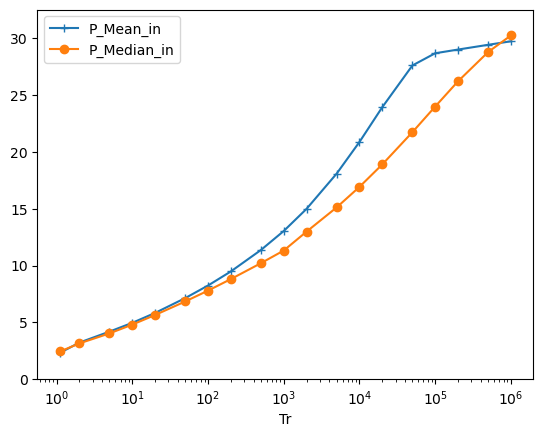

In [14]:
fit_values_mean_curve_precip = mean_curve_precip[1:20000] # Only fit the value up to about the 20,000 year event
df_GEV_parameters_E = GEV_parameters_Fit(fit_values_mean_curve_precip, 'P_Mean_in', PMP)
GEV_parameters_E = df_GEV_parameters_E.values.transpose()[0]
df_GEV_parameters = pd.concat([df_GEV_parameters, df_GEV_parameters_E], axis=1)
df_GEV_parameters
plt.show()

#### Plot fitted GEV distribution and mean precipitation curve:

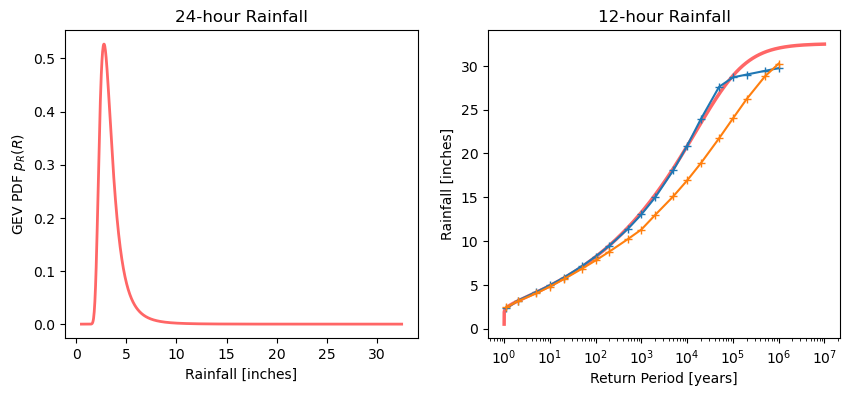

In [28]:
plot_GEV_precip_curves(mean_curve_precip, df_GEV_parameters_E, PMP, 'Rainfall')
plt.show()

### Using mean precipitation calculated in Hydrology 2 and leveraging it to generate Hydrology 4 hyetographs
We are using the mean precipitation developed in Hydrology 2. And the hyetographs are developed using the NOAA Atlas 14 temporal distributions (i.e., four different quartiles) instead of using the nested hyetograph.
#### Hydrology 2 Events:

In [83]:
CN_avg = 83  #This is basin-averaged CN and is only used in determining the runoff. And the runoff is not used in calculating mean precip.
df_weights_rainfall = weights_Rainfall(Return_Intervals, GEV_parameters_E, PMP, RI_upper_bound, mean_curve_precip, 'P_Mean_in', CN_avg, mu)
df_weights_rainfall.head(2)

,Bin Floor,Bin Ceiling,Event Weight,P_Mean_in,Runoff
2.0,1.262264,4.091671,0.547828,3.213518,1.620285
5.0,4.091671,6.286835,0.085336,4.182286,2.445157


In [92]:
# Modified function to create precip hyetograph using mean precip from Hydrology 2 and using 4 hyetographs for 4 quartiles NOAA data

def new_precip_to_runoff_h4(hydro_events:np.ndarray ,atlas14_precip_table_dir: pl.WindowsPath,
                     precip_data: pd.DataFrame,df_weights_rainfall: pd.DataFrame, display_print = False) -> tuple:
    """Takes the events, precipitation data, atlas 14 temporal distribution, selected CNs and applies the 
    CN reduction method to obtain a runoff curve for each recurrence interval. 
    """  
    Atlas14_hyetographs = ['q1', 'q2', 'q3', 'q4']
    hydro_events = list(df_weights_rainfall.index)
    column_names = []
    for event in hydro_events:
        for hyetograph in Atlas14_hyetographs:
            column_names.append(str(event)+'_'+hyetograph)
            
    prep_curves = pd.DataFrame(columns = column_names)
    prep_weights = pd.DataFrame(index = column_names, columns= ['Event Weight'])
    
    for  hyetograph in  Atlas14_hyetographs:
        for event in hydro_events:
            dist_df, weight_df = get_hyeto_input_data_atlas(atlas14_precip_table_dir, hyetograph, display_print)
            dist_df['precip'] = dist_df[hyetograph]*df_weights_rainfall['P_Mean_in'].loc[event]
            dist_df['hyeto_input'] = dist_df['precip'].diff()
            dist_df['hyeto_input'] = dist_df['hyeto_input'].fillna(0.0)
            prep_curves[str(event)+'_'+hyetograph] = dist_df['hyeto_input']
            prep_weights['Event Weight'].loc[str(event)+'_'+hyetograph] = df_weights_rainfall['Event Weight'][event]*weight_df['weight'][hyetograph]
    return prep_curves, prep_weights

#### Hydrology 4 Runoff Forcing Data:

In [118]:
#events and excess precip curves
RI_list = np.array2string(np.sort(df_weights_rainfall.index.to_numpy()))
prep_curves, prep_weights = new_precip_to_runoff_h4(RI_list,atlas14_precip_table_dir,df_weights_rainfall,df_weights_rainfall)
final_curves = extend_time(prep_curves,Time_Extend,0.1)

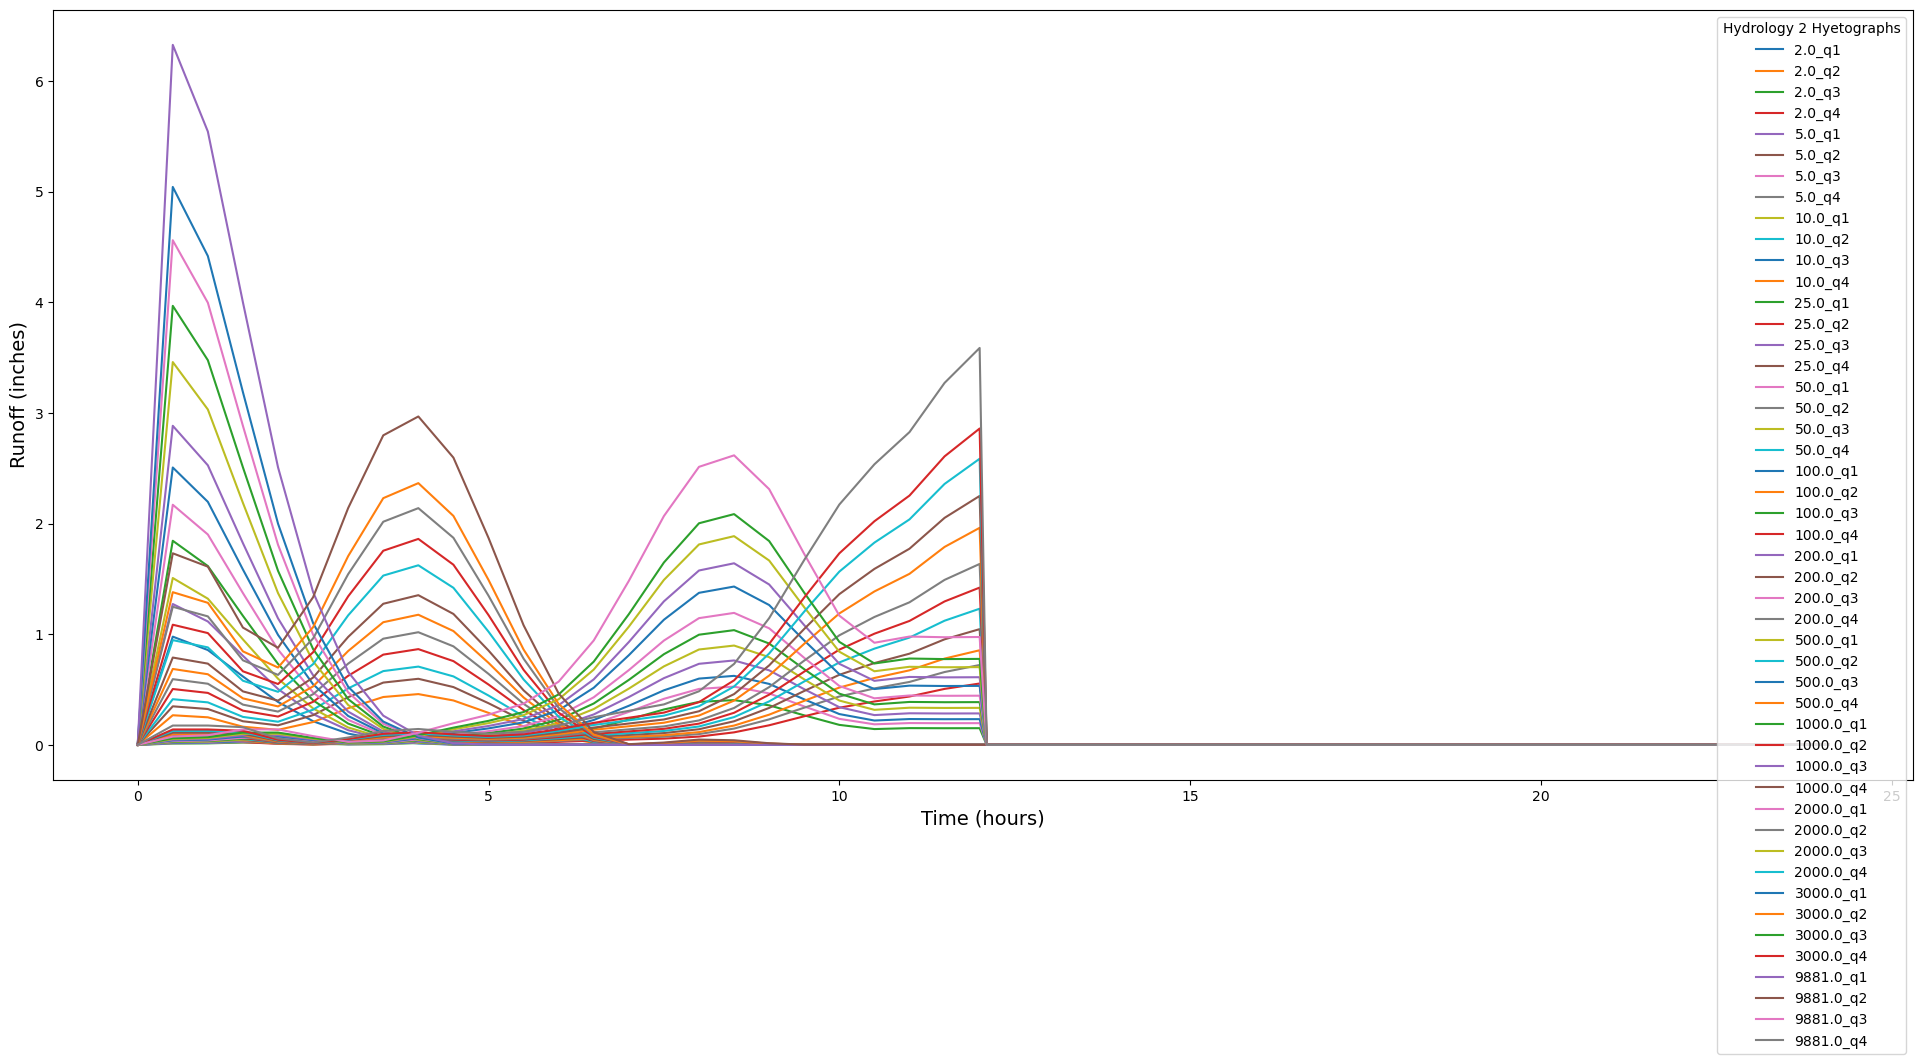

In [94]:
#graph
t_p = final_curves.plot(figsize=(24, 10))
t_p.legend(title='Hydrology 2 Hyetographs')
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)', fontsize=14)
t_p.plot();
plt.show()

In [111]:
final_curves.head(2)

,2.0_q1,2.0_q2,2.0_q3,2.0_q4,5.0_q1,5.0_q2,5.0_q3,5.0_q4,10.0_q1,10.0_q2,...,2000.0_q3,2000.0_q4,3000.0_q1,3000.0_q2,3000.0_q3,3000.0_q4,9881.0_q1,9881.0_q2,9881.0_q3,9881.0_q4
hours,,,,,,,,,,,,,,,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.5,0.978195,0.267686,0.011569,0.026994,1.273088,0.348384,0.015056,0.035131,1.508027,0.412676,...,0.053942,0.125865,5.043003,1.380033,0.059641,0.139163,6.327248,1.731471,0.074829,0.174602



## Hydrology 3 (Modified to calculate CN values for dry and wet condition):
### Retrieve Max Potential Retention Variability and Distribution Parameters:

#### This chunk of code is based on Hydrology 3. For each CN value, it extracts wet and dry soil moisture conditions, and fits into a beta distribution.

Steps involved:
1. First, all the unique Curve Number (CN) values are extracted from the basin. This is done such that we can account for the spatial variability of the CNs within a basin. Eventually, we will have wet and dry condition CN values for all the unique CNs within the basin.
2. For each unique CN value, the similar process as in Hydrology 3 is conducted. Here, for each CN, it extracts wet and dry soil moisture condition, and then fits into a beta distribution.
3. Then, the runoff data is fitted into a GEV distribution.
4. For each Return Period, the average maximum potential retention (S) values are calculated for lower 50% and upper 50%.
5. These two "S" values for each Return Period are then converted into CN by using the formula: S = 1000/CN - 10
6. In this way, we will have two sets of CN values for wet and dry conditions for each of the Return Periods. The CN values thus obtained are spatially varied instead of a single average CN value for the entire watershed.


These CN values for wet and dry conditions are then provided as an input to the HEC-RAS model. This way the RAS model acccounts for the spatial variability of the losses associated with different land use conditions throughout the basin.

In [23]:
# Extracting all the unique CN values from the CN shapefile

import geopandas as gpd

shapefile_dir = root_dir.parent.parent/'Misc'
shapefile_path = shapefile_dir/'Turkey_CN_rev/Turkey_CN_rev.shp'
shap = gpd.read_file(shapefile_path)

#Extracting unique CN values from the shapefile
unique_cn_values = shap['CN'].unique().tolist()
unique_cn_values.sort()
print(unique_cn_values)

[60, 61, 73, 74, 79, 80, 85, 90, 93, 98, 100]


In [24]:
# List of unique CN values in the basin
CN = unique_cn_values
df_weights_rainfall = {} # a dictionary to store dataframes that will be created for each CN

# Looping for all the CNs
for i in range(len(CN)):
    
    ## NRCS value of wet and dry soil moiture conditions:
    arc_data = get_CN_distribution(datarepository_dir, CN_Distribution, CN[i], display_print)
    
    ## Table of wet, dry, and average (or median) soil moisture conditions:
    df_CN = prep_cn_table(CN[i], arc_data)  
    
    ## Table of parameters for best fit of beta-type distribution to NRCS estiamted dispersion:
    fitted_cn = find_optimal_curve_beta_dist_S(df_CN)
    fitted_cn['mu'] = mu
    
    ## Distribution parameter values:
    S_limit = 1000.0/fitted_cn.iloc[0]['CN Lower Limit']-10.0
    alpha = fitted_cn.iloc[0]['alpha']
    beta = fitted_cn.iloc[0]['beta']
    
    ## Define probability for each partition of the max potential retention distribution:
    Delta_P = 1.0/n_partition
    
    ## Find the average value over each partition, which is the basis for the runoff distribution:
    partition_avg = partition_S_avgs(n_partition, Delta_P, alpha, beta, S_limit)
    
    #########################################################################################
    
    
    
    ## Error between the integral approach (based on summation integration) and the actual value:
    error_PQ = 1-CDF_Q(PMP, mu, alpha, beta, S_limit, GEV_parameters_E, PMP, partition_avg, Delta_P, 0)
    
    
    # Fit GEV to runoff data (find GEV parameters)
    df_runoff, df_GEV_parameters_R = runoff_GEV(mu, GEV_parameters_E, PMP, alpha, beta, S_limit, partition_avg, Delta_P, error_PQ)
    GEV_parameters_R = df_GEV_parameters_R.values.transpose()[0]
    
    
    # Runoff weights
    df_weights_runoff = runoff_weights(Return_Intervals, RI_upper_bound, mu, GEV_parameters_R,  GEV_parameters_E, PMP, partition_avg, Delta_P, error_PQ)
    
    # Calculate runoff and corresponding max potential retention and rainfall (average and median)
    df_runoff_SR1 = Scenarios_Avg_S_Median_S(df_weights_runoff, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit, error_PQ)
    
    # Calculate lower 50% and upper 50% max potential retention and rainfall
    df_runoff_SR2 = Scenarios_low_and_high_S(df_runoff_SR1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit, error_PQ)
    
    
    # Formatting the data
    hydro_events_orig = list(df_runoff_SR2.index)
    relabel_U = [str(hyetograph)+'_U' for hyetograph in hydro_events_orig]
    relabel_L = [str(hyetograph)+'_L' for hyetograph in hydro_events_orig]
    
    df_runoff_SR2_U = df_runoff_SR2[['Event Weight', 'Runoff', 'Avg. S (Upper 50%)', 'Rainfall (Upper 50%)']].copy()
    df_runoff_SR2_U.rename(columns = {'Avg. S (Upper 50%)': 'Avg. S', 'Rainfall (Upper 50%)': 'Rainfall'}, inplace = True)
    df_runoff_SR2_U.index = relabel_U
    
    df_runoff_SR2_L = df_runoff_SR2[['Event Weight', 'Runoff', 'Avg. S (Lower 50%)',  'Rainfall (Lower 50%)']].copy()
    df_runoff_SR2_L.rename(columns = {'Avg. S (Lower 50%)': 'Avg. S', 'Rainfall (Lower 50%)': 'Rainfall'}, inplace = True)
    df_runoff_SR2_L.index = relabel_L
    
    df_weights_rainfall[i] = pd.concat([df_runoff_SR2_U, df_runoff_SR2_L]).sort_values(by=['Runoff'])


    # Adding original CN values
    df_weights_rainfall[i]['CN_original'] = CN[i]
    
    # Calculate CN values for wet and dry conditions by using lower 50% and upper 50% max potential retention values
    CN_upd = np.int64(1000/(df_weights_rainfall[i]['Avg. S']+10))
    df_weights_rainfall[i]['CN_updated'] = CN_upd


C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey_CN\notebooks\pluvial\../../core\hydromet_stratified.py:62: RuntimeWarning:

divide by zero encountered in scalar divide

C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey_CN\notebooks\pluvial\../../core\hydromet_stratified.py:62: RuntimeWarning:

divide by zero encountered in scalar divide

C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey_CN\notebooks\pluvial\../../core\hydromet_stratified.py:62: RuntimeWarning:

divide by zero encountered in scalar divide

C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey_CN\notebooks\pluvial\../../core\hydromet_stratified.py:62: RuntimeWarning:

divide by zero encountered in scalar divide

C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey_CN\notebooks\pluvial\../../core\hydromet.py:489: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey_CN\notebooks\pluvial\../../core\hydromet_stratified.py:197: Runt

ValueError: An upper bound is less than the corresponding lower bound.

In [26]:
# Dictionary to store the new dataframes for individual events, for e.g. 2_U, 2_L and so on. Basically rearranging the updated CN values based on individual events
event_dfs = {}

# Iterating over each dataframe (i.e., for each event) in df_weights_rainfall
for key, df in df_weights_rainfall.items():
    for event in df.index.unique():  # Extracting unique index values as the return periods are stored as index
        if event not in event_dfs:
            event_dfs[event] = pd.DataFrame()
        event_dfs[event] = pd.concat([event_dfs[event], df.loc[[event]]])  # Selecting rows by index

# Assign each dataframe a variable dynamically (optional)
globals().update(event_dfs)


### Remarks regarding the 12th event
There is one caveat to notice while using this approach. For each CN value, we get different Return periods and rainfall value for the 12th event. This is due to the fact that the Return Period and Rainfall for the 12th event is calculated based on the conditional probability of Runoff(Q) dependent on Max. potential retention (S). And since we have different CN values, we will have different distribution of max potential retention (S). As a result, we tend to get different return period values for each CN, which is shown in cell below.

However, since we are only interested in wet and dry condition Curve Numbers (CN), the different Return Period and Rainfall values will not impact our approach and the subsequent analysis. 
As for the rainfall and return period values, we are using the rainfall developed using Hydrology 2 approach. And Hydrology 2 produces a single value of rainfall and return period for the 12th event.

In [115]:
list(event_dfs.items())[-10:]

[('9742_U',
          Event Weight     Runoff    Avg. S   Rainfall  CN_original  CN_updated
  9742_U      0.000135  17.891884  3.853207  21.921952           80          72),
 ('9742_L',
          Event Weight     Runoff    Avg. S   Rainfall  CN_original  CN_updated
  9742_L      0.000135  17.891884  1.190807  19.250664           80          89),
 ('9795_U',
          Event Weight     Runoff    Avg. S   Rainfall  CN_original  CN_updated
  9795_U      0.000135  18.586909  2.952599  21.768754           85          77),
 ('9795_L',
          Event Weight     Runoff    Avg. S   Rainfall  CN_original  CN_updated
  9795_L      0.000135  18.586909  0.879155  19.603833           85          91),
 ('9891_U',
          Event Weight    Runoff    Avg. S   Rainfall  CN_original  CN_updated
  9891_U      0.000135  19.27867  2.040736  21.547894           90          83),
 ('9891_L',
          Event Weight    Runoff    Avg. S   Rainfall  CN_original  CN_updated
  9891_L      0.000135  19.27867  0.64204

In [116]:
list(event_dfs.items())[0]

('2_U',
      Event Weight    Runoff    Avg. S  Rainfall  CN_original  CN_updated
 2_U      0.275956  0.456865  9.261532  4.150388           60          51
 2_U      0.275978  0.464406  9.025549  4.097758           61          52
 2_U      0.274307  0.961659  5.641141  3.987303           73          63
 2_U      0.274508  1.018876  5.420196  3.998063           74          64
 2_U      0.274465  1.302187  4.187913  3.913005           79          70
 2_U      0.274428  1.328109  4.013558  3.869142           80          71
 2_U      0.274187  1.654553  2.986481  3.796423           85          77
 2_U      0.274301  2.005466  1.995000  3.639227           90          83
 2_U      0.274335  2.244374  1.521591  3.588524           93          86
 2_U      0.273919  2.814925  0.468971  3.318141           98          95)

#### Saving the calculated dry and wet condition CNs for each event into a separate shapefile

In [48]:
# Only accessing the events other than the 12th event, since the return period for the 12th event was not consistent (which is described earlier)
dict_event = event_dfs
dict_event = {key: dict_event[key] for key in list(dict_event.keys())[:-20]}

print(dict_event.keys())

dict_keys(['2_U', '2_L', '5_U', '5_L', '10_U', '10_L', '25_U', '25_L', '50_U', '50_L', '100_L', '100_U', '200_L', '200_U', '500_L', '500_U', '1000_L', '1000_U', '2000_L', '2000_U', '3000_L', '3000_U'])


In [49]:
#Saving the wet and dry CNs for each event to a separate shapefile
import pandas as pd

# Output folder for updated CN shapefiles
CN_output_folder = shapefile_dir/'Turkey_CN_rev/'

for name, df in dict_event.items():
    cn_mapping = dict(zip(df["CN_original"], df["CN_updated"]))   # creating a mapping of original and updated CN
    shap["CN_updated"] = shap["CN"].map(cn_mapping).fillna(shap["CN"])   # updating CN values directly in shapefiles

    output_path_CN = f"{CN_output_folder}/{name}.shp"
    shap.to_file(output_path_CN)

    print(f"Updated shapefile saved: {output_path_CN}")


Updated shapefile saved: C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey_CN\Misc\Turkey_CN_rev/2_U.shp
Updated shapefile saved: C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey_CN\Misc\Turkey_CN_rev/2_L.shp
Updated shapefile saved: C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey_CN\Misc\Turkey_CN_rev/5_U.shp
Updated shapefile saved: C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey_CN\Misc\Turkey_CN_rev/5_L.shp
Updated shapefile saved: C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey_CN\Misc\Turkey_CN_rev/10_U.shp
Updated shapefile saved: C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey_CN\Misc\Turkey_CN_rev/10_L.shp
Updated shapefile saved: C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey_CN\Misc\Turkey_CN_rev/25_U.shp


KeyboardInterrupt: 

---
# End